In [1]:
import sys
sys.path.append('..')
from pathlib import Path
import numpy as np
import h5py
import jax
import jax.numpy as jnp
import yaml
import matplotlib.pyplot as plt

import flowrec.training_and_states as state_utils
import flowrec.data as data_utils
import flowrec.physics_and_derivatives as derivatives

from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.interpolate import RBFInterpolator
from flowrec.utils import simulation
from flowrec import losses
from flowrec.utils.py_helper import slice_from_tuple
from flowrec.utils.system import set_gpu
# set_gpu(0,1)
jax.config.update('jax_platform_name', 'cpu')

In [2]:
plt.style.use('../flowrec/utils/ppt.mplstyle')
# plt.style.use('../flowrec/utils/a4.mplstyle')

In [3]:
results_dir = Path('../test_volvo_training') #

if results_dir.exists():
    ! ls $results_dir
else:
    raise ValueError('This directory does not exist.')

config.yml  results.h5	state.npy  state.pkl


# Load configurations and learning curve

None


/tmp/ipykernel_1593511/4209660246.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loss_train = np.array(hf.get("loss_train"))
/tmp/ipykernel_1593511/4209660246.py:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loss_val = np.array(hf.get("loss_val"))
/tmp/ipykernel_1593511/4209660246.py:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loss_div = np.array(hf.get("loss_div"))
/tmp/ipykernel_1593511/4209660246.py:9: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loss_momentum = np.array(hf.get("loss_momentum"))
/tmp/ipykernel_1593511/4209660246.py:10: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` i

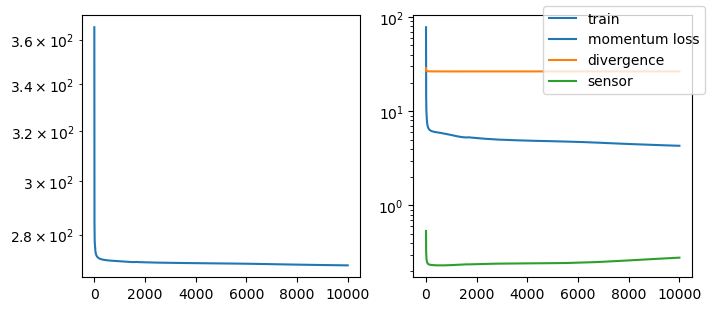

In [4]:
with open(Path(results_dir,'config.yml'),'r') as f:
    cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
cfg.data_config.update({'data_dir':'.'+cfg.data_config.data_dir})

with h5py.File(Path(results_dir,'results.h5'),'r') as hf:
    loss_train = np.array(hf.get("loss_train"))
    loss_val = np.array(hf.get("loss_val"))
    loss_div = np.array(hf.get("loss_div"))
    loss_momentum = np.array(hf.get("loss_momentum"))
    loss_sensors = np.array(hf.get("loss_sensors"))
print(cfg.data_config.snr)
fig, ax = plt.subplots(1,2,figsize=(7,3))
ax[0].semilogy(loss_train, label='train')
ax[1].semilogy(loss_momentum, label='momentum loss')
ax[1].semilogy(loss_div, label='divergence')
ax[1].semilogy(loss_sensors, label='sensor')
fig.legend()
plt.show()

# Load data

In [5]:
from train_config.train_options.dataloader import dataloader_3dvolvo as dataloader

In [6]:
data, datainfo = dataloader(cfg.data_config)
print(datainfo)
print(data.keys())

_Metadata3d(re=45272.49849853186, discretisation=(0.10374418999999165, 0.03205128205128194, 0.02631578947368436, 0.031578947368421026), axis_index=(0, 1, 2, 3), axt=0, axx=1, axy=2, axz=3, dt=0.10374418999999165, dx=0.03205128205128194, dy=0.02631578947368436, dz=0.031578947368421026)
dict_keys(['u_train_clean', 'u_val_clean', 'u_train', 'u_val', 'inn_train', 'inn_val'])


In [7]:
u_train = data['u_train']
inn_train = data['inn_train']

In [23]:
cfg.case

_case_dataloader: !!python/object:ml_collections.config_dict.config_dict.FieldReference
  _field_type: &id001 !!python/name:builtins.str ''
  _ops: []
  _required: false
  _value: 3dvolvo
_case_loss_fn: !!python/object:ml_collections.config_dict.config_dict.FieldReference
  _field_type: *id001
  _ops: []
  _required: false
  _value: physicswithdata
_case_observe: !!python/object:ml_collections.config_dict.config_dict.FieldReference
  _field_type: *id001
  _ops: []
  _required: false
  _value: grid_pin
_case_select_model: !!python/object:ml_collections.config_dict.config_dict.FieldReference
  _field_type: *id001
  _ops: []
  _required: false
  _value: fc2branch
dataloader: !!python/name:train_config.train_options.dataloader.dataloader_3dvolvo ''
loss_fn: !!python/name:train_config.train_options.loss_fn.loss_fn_physicswithdata ''
observe: !!python/name:train_config.train_options.observe.observe_grid_pin ''
select_model: !!python/name:train_config.train_options.select_model.select_model_f

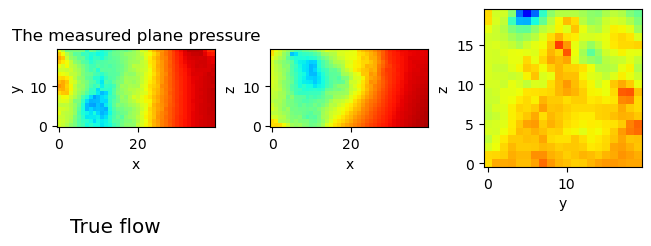

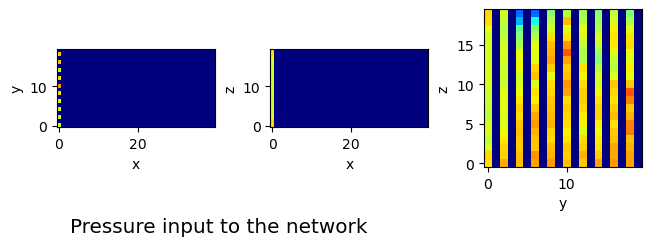

In [25]:
vmin = u_train[0,...,-1].min()
vmax = u_train[0,...,-1].max()
fig, axes = plt.subplots(1, 3)
axes[0].set_title('The measured plane pressure')
axes[0].imshow(u_train[0,:,:,10,-1].T, vmin=vmin, vmax=vmax)
axes[0].set(xlabel='x', ylabel='y')
axes[1].imshow(u_train[0,:,0,:,-1].T, vmin=vmin, vmax=vmax)
axes[1].set(xlabel='x', ylabel='z')
axes[2].imshow(u_train[0,0,:,:,-1].T, vmin=vmin, vmax=vmax)
axes[2].set(xlabel='y', ylabel='z')
fig.text(0.1,0.2,'True flow',fontsize='x-large')
plt.show()


plotinlet = np.zeros_like(u_train[0,:,:,:,-1])
s_inn = slice_from_tuple(cfg.data_config.pressure_inlet_slice)
plotinlet[s_inn] = inn_train[0,:].reshape(plotinlet[s_inn].shape)
fig, axes = plt.subplots(1, 3)
axes[0].imshow(plotinlet[:,:,10].T, vmin=vmin, vmax=vmax)
axes[0].set(xlabel='x', ylabel='y')
axes[1].imshow(plotinlet[:,0,:].T, vmin=vmin, vmax=vmax)
axes[1].set(xlabel='x', ylabel='z')
axes[2].imshow(plotinlet[0,:,:].T, vmin=vmin, vmax=vmax)
axes[2].set(xlabel='y', ylabel='z')
fig.text(0.1,0.2,'Pressure input to the network',fontsize='x-large')
plt.show()


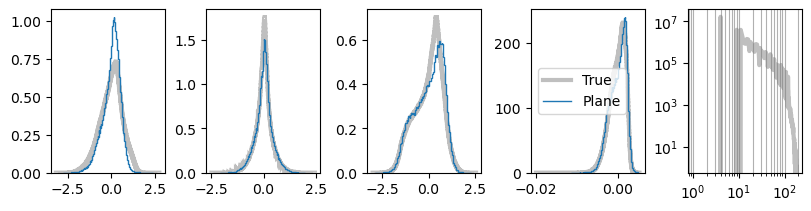

In [31]:
fig, axes = plt.subplots(1,5,figsize=(8,2))
for i,ax in enumerate(axes[:-1]):
    counts_true, bins_true = np.histogram(u_train[...,i].flatten()-np.mean(u_train[...,i].flatten(),axis=0), density=True, bins='auto')
    ax.stairs(counts_true,bins_true,linewidth=3, color='#808080',alpha=0.5, label='True')
    counts,bins= np.histogram(u_train[...,10,i].flatten()-np.mean(u_train[...,10,i].flatten()), density=True, bins='auto')
    ax.stairs(counts,bins, label='Plane')
axes[3].legend()

spectrum_true, kbins_true = derivatives.get_tke(u_train[...,:-1]-np.mean(u_train[...,:-1],axis=0), datainfo)
axes[4].loglog(kbins_true,spectrum_true,label='ref',linewidth=3, color='#808080',alpha=0.5)
axes[4].grid(which='both',axis='x')
plt.show()

# Build model

In [9]:
state = state_utils.restore_trainingstate(results_dir,'state')
jax.tree_util.tree_map(lambda x: print(x.shape),state.params)

(4,)
(3, 3, 3, 4, 4)
(1,)
(3, 3, 3, 4, 1)
(8,)
(3, 3, 3, 4, 8)
(16,)
(3, 3, 3, 8, 16)
(8,)
(3, 3, 3, 16, 8)
(4,)
(3, 3, 3, 9, 4)
(8000,)
(200, 8000)


{'fourier2_branch/~/branch0_conv': {'b': None, 'w': None},
 'fourier2_branch/~/branch1_conv_0': {'b': None, 'w': None},
 'fourier2_branch/~/branch2_conv_0': {'b': None, 'w': None},
 'fourier2_branch/~/branch2_conv_1': {'b': None, 'w': None},
 'fourier2_branch/~/branch2_conv_2': {'b': None, 'w': None},
 'fourier2_branch/~/branch3_conv_0': {'b': None, 'w': None},
 'fourier2_branch/~/mlp/~/linear_0': {'b': None, 'w': None}}

In [10]:
_, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
mdl = make_model(cfg.model_config)

In [11]:
## Normalise
if cfg.data_config.normalise:
    raise ValueError('Do something here.')

In [12]:
rng = jax.random.PRNGKey(10)

pb_train_batch = np.array_split(inn_train,2,0)
pred_train = []
for inn in pb_train_batch:
    pred_train.append(mdl.apply(state.params,rng,inn,TRAINING=False))
pred_train = np.concatenate(pred_train)

# Results

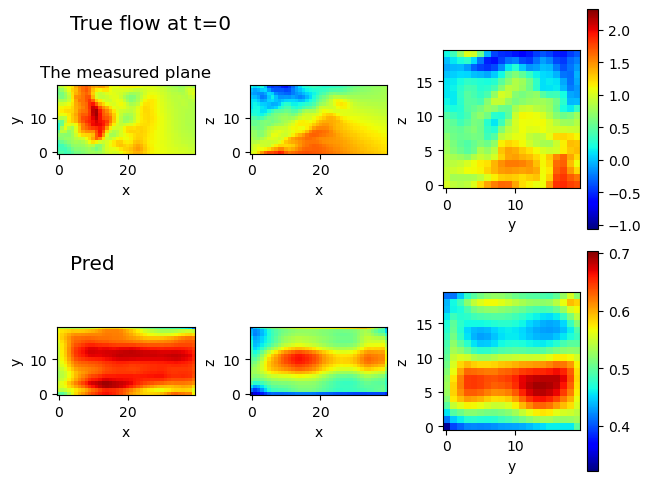

In [13]:
plt_t = 0
which_component = 0
vmax = u_train[plt_t,...,which_component].max()
vmin = u_train[plt_t,...,which_component].min()

fig, axes = plt.subplots(2, 3)
axes[0,0].set_title('The measured plane')
axes[0,0].imshow(u_train[plt_t,:,:,10,which_component].T, vmin=vmin, vmax=vmax)
axes[0,0].set(xlabel='x', ylabel='y')
axes[0,1].imshow(u_train[plt_t,:,0,:,which_component].T, vmin=vmin, vmax=vmax)
axes[0,1].set(xlabel='x', ylabel='z')
imtrue = axes[0,2].imshow(u_train[plt_t,0,:,:,which_component].T, vmin=vmin, vmax=vmax)
plt.colorbar(imtrue)
axes[0,2].set(xlabel='y', ylabel='z')
fig.text(0.1,0.95,f'True flow at t={plt_t}',fontsize='x-large')


vmax = pred_train[plt_t,...,which_component].max()
vmin = pred_train[plt_t,...,which_component].min()
axes[1,0].imshow(pred_train[plt_t,:,:,10,which_component].T, vmin=vmin, vmax=vmax)
axes[1,0].set(xlabel='x', ylabel='y')
axes[1,1].imshow(pred_train[plt_t,:,0,:,which_component].T, vmin=vmin, vmax=vmax)
axes[1,1].set(xlabel='x', ylabel='z')
impred = axes[1,2].imshow(pred_train[plt_t,0,:,:,which_component].T, vmin=vmin, vmax=vmax)
plt.colorbar(impred)
axes[1,2].set(xlabel='y', ylabel='z')
fig.text(0.1,0.45,'Pred',fontsize='x-large')
plt.show()


In [14]:
@jax.tree_util.Partial(jax.jit,static_argnames=('datainfo'))
def vorticity(u, datainfo):
    """Calculate vorticity field.\n
    
    Arguments:\n
        u: [...,u], last dimension must be velocity.\n
        datainfo: an instance of DataMetadata.\n
    
    Return:\n
        vorticity: of shape [1,x,y,z]
    """

    step_space = datainfo.discretisation[1:]
    axis_space = datainfo.axis_index[1:]
    u = jnp.moveaxis(u[...],-1,0) # move velocity axis to 0
    v_derivative1 = jax.vmap(derivatives.derivative1,(0,None,None),0)
    def _didj(de_fun,inn):
        didj_T = de_fun(inn,datainfo.dx,datainfo.axx).reshape((-1,)+inn.shape)
        for j in range (1,u.shape[0]):
            didj_T = jnp.concatenate(
                (
                didj_T,
                de_fun(inn,step_space[j],axis_space[j]).reshape((-1,)+inn.shape)
                ),
                axis=0
            )
        return didj_T # for de_fun = v_derivative1 and inn=u -> [j,i,t,x,y,z]
    
    dui_dxj = jnp.einsum('jit... -> ijt...', _didj(v_derivative1, u)) # [i,j,t,x,y,z]

    vort = dui_dxj[1,0,...] - dui_dxj[0,1,...]
    if len(axis_space) == 2:
        return vort
    elif len(axis_space) == 3:
        vort2 = vort
        vort0 = dui_dxj[2,1,...] - dui_dxj[1,2,...]
        vort1 = dui_dxj[0,2,...] - dui_dxj[2,0,...]
        return jnp.stack([vort0,vort1,vort2], )
    else:
        raise ValueError


In [15]:
u_train.shape

(450, 40, 20, 20, 4)

In [16]:
div = derivatives.div_field(pred_train[...,:-1], datainfo)
momentum = derivatives.momentum_residual_field(pred_train, datainfo)
print(div.max(), div.min(), momentum.max(), momentum.min())
div_ref = derivatives.div_field(u_train[...,:-1], datainfo)
momentum_ref = derivatives.momentum_residual_field(u_train, datainfo)
print(div_ref.max(), div_ref.min(), momentum_ref.max(), momentum_ref.min())

1.5753253 -0.73053026 14.259171 -4.8569956
28.977829 -30.345608 181.4486 -146.37764


In [24]:
l_div = losses.divergence(pred_train[...,:-1],datainfo)
l_momentum = losses.momentum_loss(pred_train,datainfo)
l_div_ref = losses.divergence(u_train[...,:-1],datainfo)
l_momentum_ref = losses.momentum_loss(u_train,datainfo)
l_mse_slice = losses.mse(pred_train[...,10,:],u_train[...,10,:])
l_rel = losses.relative_error(pred_train, u_train)
print(f'ref momentum loss: {l_momentum_ref:.5f}, ref divergence loss: {l_div_ref:.5f}')
print(f'pred momentum loss: {l_momentum:.5f}, pred divergence loss: {l_div:.5f}')
print(f'Relative error of the domain {l_rel*100:.3f}%')
print(f'Relative error of the domain close to the measured plane from z=5 to z=15 {100*losses.relative_error(pred_train[...,5:15,:], u_train[...,5:15,:]):.5f}%')
print(f'MSE of the domain close to the measured plane from z=5 to z=15 {100*losses.mse(pred_train[...,5:15,:], u_train[...,5:15,:]):.5f}')
print(f'MSE of the measured plane {l_mse_slice:5f}')


ref momentum loss: 83.12672, ref divergence loss: 1.50023
pred momentum loss: 0.55354, pred divergence loss: 0.01429
Relative error of the domain 65.051%
Relative error of the domain close to the measured plane from z=5 to z=15 62.46124%
MSE of the domain close to the measured plane from z=5 to z=15 25.50393
MSE of the measured plane 0.247394


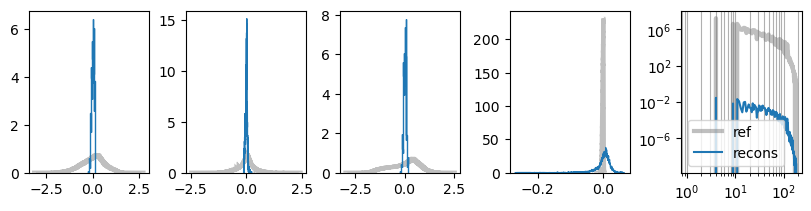

In [32]:
fig, axes = plt.subplots(1,5,figsize=(8,2))
for i,ax in enumerate(axes[:-1]):
    counts_true, bins_true = np.histogram(u_train[...,i].flatten()-np.mean(u_train[...,i].flatten(),axis=0), density=True, bins='auto')
    ax.stairs(counts_true,bins_true,label='true',linewidth=3, color='#808080',alpha=0.5)
    counts,bins= np.histogram(pred_train[...,i].flatten()-np.mean(pred_train[...,i].flatten()), density=True, bins='auto')
    ax.stairs(counts,bins,label='recons')

spectrum_true, kbins = derivatives.get_tke(u_train-np.mean(u_train,axis=0), datainfo)
spectrum, _ = derivatives.get_tke(pred_train-np.mean(pred_train,axis=0), datainfo)
axes[4].loglog(kbins,spectrum_true,label='ref',linewidth=3, color='#808080',alpha=0.5)
axes[4].loglog(kbins,spectrum,label='recons')
axes[4].grid(which='both',axis='x')
axes[4].legend()
plt.show()

In [17]:
w = vorticity(pred_train[...,:-1], datainfo)

In [19]:
div1 = derivatives.div_field(np.einsum('it... -> t...i',w),datainfo)
div1.max(), div1.min()

(Array(0.00024033, dtype=float32), Array(-0.00025558, dtype=float32))